# Procedural Noise

Brendan Harmon  
2025-07-18

<figure>
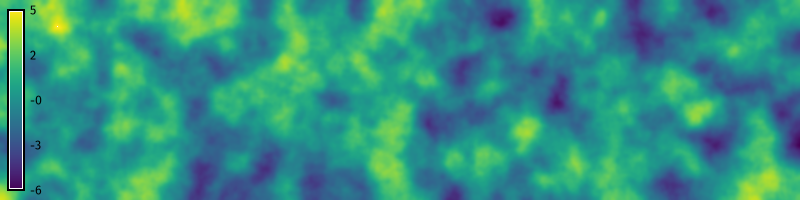
<figcaption aria-hidden="true">Fractal Brownian motion</figcaption>
</figure>

This tutorial is an introduction to generating procedural noise with
Python scripting in GRASS. The computer graphics community has developed
stochastic functions for procedurally modeling textures. These
procedural noise functions are useful for generating synthetic data
representing stochastic natural phenomena such as terrain, water, and
clouds. Let’s implement procedural noise using map algebra in GRASS!
This tutorial covers:

-   Random walks
-   Gradient noise
-   Billow noise
-   Ridge noise
-   Fractal noise
-   Multifractal noise

> **Computational notebook**
>
> This tutorial can be run as a [computational
> notebook](https://grass-tutorials.osgeo.org/content/tutorials/noise/noise.ipynb).
> Learn how to work with notebooks in the tutorial [Get started with
> GRASS & Python in Jupyter
> Notebooks](../get_started/fast_track_grass_and_python.qmd).

# Setup

Start a GRASS session in a new project with a Cartesian (XY) coordinate
system. Use
[g.region](https://grass.osgeo.org/grass-stable/manuals/g.region.html)
to set the extent and resolution of the computational region. Create a
region starting at the origin and extending two hundred units north and
eight hundred units east.

In [1]:
# Import libraries
import os
import sys
import subprocess
from pathlib import Path

# Find GRASS Python packages
sys.path.append(
  subprocess.check_output(
    ["grass", "--config", "python_path"],
    text=True
    ).strip()
  )

# Import GRASS packages
import grass.script as gs
import grass.jupyter as gj

# Create a temporary folder
import tempfile
temporary = tempfile.TemporaryDirectory()

# Create a project in the temporary directory
gs.create_project(path=temporary.name, name="xy")

# Start GRASS in this project
session = gj.init(Path(temporary.name, "xy"))

# Set region
gs.run_command("g.region", n=200, e=800, s=0, w=0, res=1)

# Random Walks

In a random walk, a walker traverses a space by taking a sequence of
steps in random directions. Random walks can used to simulate stochastic
processes such as migration, searching, foraging, accumulation, and
diffusion. Depending on the number of walkers and steps, 2-dimensional
random walks can create sparse or dense stochastic surfaces, which can
be useful for generating other forms of procedural noise. In GRASS,
2-dimensional random walks can be generated with the addon
[r.random.walk](https://grass.osgeo.org/grass-stable/manuals/addons/r.random.walk.html).
Walkers will traverse the computational region, each stepping cell by
cell in a random direction across a raster grid. The output raster
records the frequency of visits per cell. First install
[r.random.walk](https://grass.osgeo.org/grass-stable/manuals/addons/r.random.walk.html)
with
[g.extension](https://grass.osgeo.org/grass-stable/manuals/g.extension.html).

In [2]:
gs.run_command("g.extension", extension="r.random.walk")

Then run
[r.random.walk](https://grass.osgeo.org/grass-stable/manuals/addons/r.random.walk.html)
with multiple walkers. Experiment with the parameters. Try varying the
number of steps and walkers. If it runs slowly, try increasing the
memory or number of processes. The resulting random walk can be used
instead of an initial random or fractal surface in the following
sections of this tutorial.

In [3]:
# Set parameters
directions = 8
steps = 50000
walkers = 10
memory = 1200

# Generate random walks
gs.run_command(
    "r.random.walk",
    output="walk",
    directions=directions,
    steps=steps,
    nwalkers=walkers,
    memory=memory,
    flags="s",
    overwrite=True
    )

# Set color gradient
gs.run_command("r.colors", map="walk", color="viridis")

# Visualize
m = gj.Map(width=800)
m.d_rast(map="walk")
m.d_legend(raster="walk", color="white", at=(5, 95, 1, 3))
m.show()

<figure>
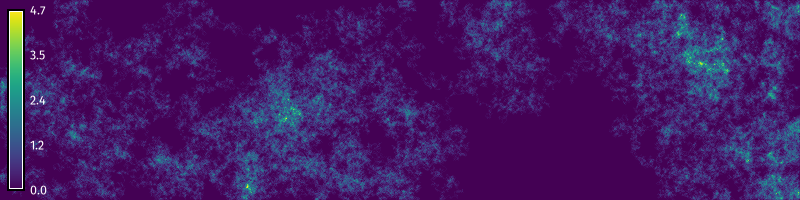
<figcaption aria-hidden="true">Random walks</figcaption>
</figure>

# Gradient Noise

The original form of gradient noise - Perlin noise - is generated by
interpolating between random gradient vectors on a grid and their
offsets ([Perlin 1985](https://doi.org/10.1145/325165.325247)). We will
use map algebra to generate a generalized form of gradient noise by
progressively smoothing a random raster surface. First create a random
surface using the raster calculator
[r.mapcalc](https://grass.osgeo.org/grass-stable/manuals/r.mapcalc.html).
Use [formatted string
literals](https://docs.python.org/3/tutorial/inputoutput.html#tut-f-strings)
to insert variables into raster calculator expressions in Python
scripts. Then use a `for` loop to progressively smooth the random
surface using nearest neighbors analysis with
[r.neighbors](https://grass.osgeo.org/grass-stable/manuals/r.neighbors.html).
Calculate the average neighborhood using a circular moving window. The
key parameters for our gradient noise function are the `seed` of the
pseudo-random number generator, the `amplitude` of the surface, the
`iterations` of smoothing, and the `wavelength` of the moving window.
Experiment with these parameters. Try setting different values for each
of them. Then try using random walks generated with
[r.random.walk](https://grass.osgeo.org/grass-stable/manuals/addons/r.random.walk.html)
or a fractal surface generated with
[r.surf.fractal](https://grass.osgeo.org/grass-stable/manuals/r.surf.fractal.html)
instead of a random surface.

In [4]:
# Set parameters
seed = 0
amplitude = 100.0
iterations = 3
wavelength = 33

# Generate random surface
gs.mapcalc(f"noise = rand({-amplitude}, {amplitude})", seed=seed)

# Generate gradient noise
for i in range(iterations):

    # Smooth noise
    gs.run_command(
      "r.neighbors",
      input="noise",
      output="noise",
      size=wavelength,
      method="average",
      flags="c",
      overwrite=True
      )

# Set color gradient
gs.run_command("r.colors", map="noise", color="viridis")

# Visualize
m = gj.Map(width=800)
m.d_rast(map="noise")
m.d_legend(raster="noise", at=(5, 95, 1, 3))
m.show()

<figure>
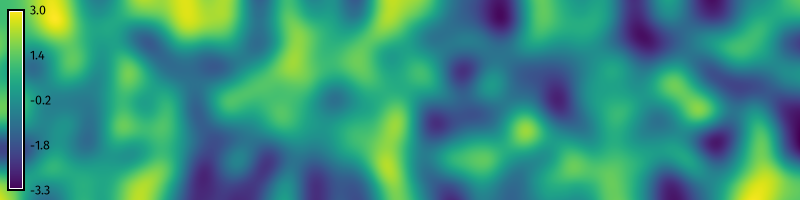
<figcaption aria-hidden="true">Gradient noise</figcaption>
</figure>

# Billow Noise

Billow noise or turbulence is a variation of gradient noise. After
generating gradient noise, use the raster map calculator
[r.mapcalc](https://grass.osgeo.org/grass-stable/manuals/r.mapcalc.html)
to take the absolute value of the noise raster. This will transform pits
and valleys into peaks and ridges and form new valleys near zero
elevation, creating a billowing cloudy effect.

In [5]:
# Set parameters
seed = 0
amplitude = 100.0
iterations = 3
wavelength = 33

# Generate random surface
gs.mapcalc(f"noise =  rand(-{amplitude}, {amplitude})", seed=seed)

# Generate perlin noise
for i in range(iterations):

    # Smooth noise
    gs.run_command(
      "r.neighbors",
      input="noise",
      output="noise",
      size=wavelength,
      method="average",
      flags="c",
      overwrite=True
      )

# Calculate absolute value
gs.mapcalc("turbulence =  abs(noise)")

# Visualize
m = gj.Map(width=800)
m.d_rast(map="turbulence")
m.d_legend(raster="turbulence", color="white", at=(5, 95, 1, 3))
m.show()

<figure>
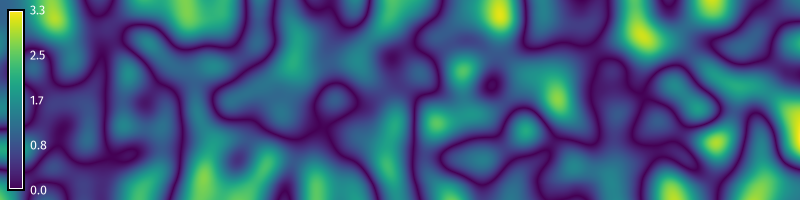
<figcaption aria-hidden="true">Billow noise</figcaption>
</figure>

# Ridge Noise

Ridge noise is another variation of gradient noise. After generating
gradient noise, use the raster map calculator
[r.mapcalc](https://grass.osgeo.org/grass-stable/manuals/r.mapcalc.html)
to subtract the absolute value of the noise raster from an offset and
then raise it to an exponent. This will transform the valleys of billow
noise into ridges. The key parameters for our ridge noise function are
the `seed` of the pseudo-random number generator, the `amplitude` of the
surface, the `iterations` of smoothing, the `wavelength` of the moving
window, the `offset` of the ridges, and the `exponent` for scaling the
ridges.

In [6]:
# Set parameters
seed = 0
amplitude = 100.0
iterations = 3
wavelength = 33
offset = 10
exponent = 2

# Generate random surface
gs.mapcalc(f"noise =  rand(-{amplitude}, {amplitude})", seed=seed)

# Generate perlin noise
for i in range(iterations):

    # Smooth noise
    gs.run_command(
      "r.neighbors",
      input="noise",
      output="noise",
      size=wavelength,
      method="average",
      flags="c",
      overwrite=True
      )

# Calculate ridge function
gs.mapcalc(f"ridge =  exp({offset} - abs(noise), {exponent})")

# Visualize
m = gj.Map(width=800)
m.d_rast(map="ridge")
m.d_legend(raster="ridge", at=(5, 95, 1, 3))
m.show()

<figure>
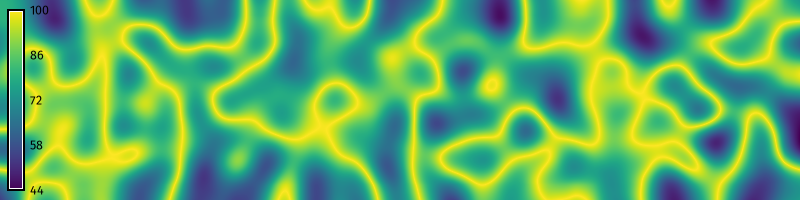
<figcaption aria-hidden="true">Ridge noise</figcaption>
</figure>

# Fractal Noise

Fractional Brownian motion is a random walk through space that is
contingent on past steps and has self-similar fractal properties.
Fractal noise can be generated from fractional Brownian motion by
accumulating octaves, i.e. iterations, of procedural noise with
incremental changes in frequency and amplitude ([Musgrave
2003](https://doi.org/10.1016/B978-155860848-1/50045-0), [Vivo & Lowe
2015](https://thebookofshaders.com/13/), [Quilez
2019](https://iquilezles.org/articles/fbm/)). First, use the raster map
calculator
[r.mapcalc](https://grass.osgeo.org/grass-stable/manuals/r.mapcalc.html)
to create a constant surface. Then use a `for` loop to iterate through
each octave. For each octave, generate gradient noise, add the gradient
noise to the prior surface using
[r.mapcalc](https://grass.osgeo.org/grass-stable/manuals/r.mapcalc.html),
and then increment the function’s fractal parameters. The key parameters
for our fractal Brownian motion function are the `seed` of the
pseudo-random number generator, the `amplitude` of the surface, the
`iterations` of smoothing, the `wavelength` of the moving window, the
`octaves` for accumulating noise, the `lacunarity` or change in
frequency of each octave, and the `gain` in amplitude for each octave.

In [7]:
# import libraries
import random

# Set parameters
seed = 0
amplitude = 100.0
iterations = 3
wavelength = 33
octaves = 6
lacunarity = 0.5
gain = 0.2

# Generate zeros
gs.mapcalc("fbm = 0")

# Generate fractional Brownian motion
for octave in range(octaves):

    # Generate random surface
    gs.mapcalc(f"noise = rand(-{amplitude}, {amplitude})", seed=seed)
    
    # Generate gradient noise
    for i in range(iterations):
    
        # Smooth noise
        gs.run_command(
          "r.neighbors",
          input="noise",
          output="noise",
          size=wavelength,
          method="average",
          flags="c",
          overwrite=True
          )

    # Calculate sum of gradient noise maps
    gs.mapcalc("fbm = fbm + noise")

    # Increment parameters
    amplitude = amplitude * gain
    wavelength = round(wavelength * lacunarity)
    if wavelength % 2 == 0:
        wavelength += 1

# Visualize
m = gj.Map(width=800)
m.d_rast(map="fbm")
m.d_legend(raster="fbm", at=(5, 95, 1, 3))
m.show()

<figure>
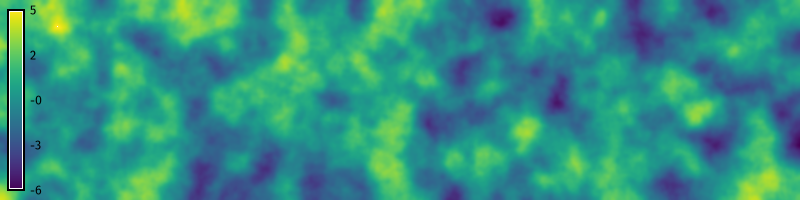
<figcaption aria-hidden="true">Fractal Brownian motion</figcaption>
</figure>

# Multifractal noise

Multifractal noise can be generated by more complex incremental
accumulations of procedural noise ([Musgrave et
al. 1989](https://doi.org/10.1145/325165.325247), [Musgrave
2004](https://doi.org/10.1145/1103900.1103932)). In this example we will
model multifractal Brownian motion by accumulating octaves of turbulent
fractal gradient noise. First, use the raster map calculator
[r.mapcalc](https://grass.osgeo.org/grass-stable/manuals/r.mapcalc.html)
to create a constant surface. Then use a `for` loop to iterate through
each octave. For each octave, generate a fractal surface with
[r.surf.fractal](https://grass.osgeo.org/grass-stable/manuals/r.surf.fractal.html),
progressive smooth this surface in a nested `for` loop to model fractal
gradient noise, add the absolute value of fractal gradient noise to the
prior surface scaled by amplitude, and then increment the function’s
fractal parameters. Experiment with different parameters. Try
multiplying fractal maps instead of adding them, but be sure to start
with a non-zero constant to avoid multiplication by zero. The key
parameters for our multifractal function are the `seed` of the
pseudo-random number generator, the `dimension` of the fractal surface,
the `amplitude` of the multifractal surface, the `iterations` of
smoothing, the `wavelength` of the moving window, the `octaves` for
accumulating noise, the `lacunarity` of each octave, and the `gain` in
amplitude for each octave.

In [8]:
# Set parameters
seed = 0
amplitude = 0.1
iterations = 3
wavelength = 33
octaves = 6
lacunarity = 0.5
gain = 0.05
dimension = 2.2

# Generate zeros
gs.mapcalc("multifractal = 0")

# Generate multifractal surface
for octave in range(octaves):
    
    # Generate fractal surface
    gs.run_command(
        "r.surf.fractal",
        output="fractal",
        dimension=dimension,
        seed=seed
        )

    # Generate fractal gradient noise
    for i in range(iterations):
    
        # Smooth noise
        gs.run_command(
          "r.neighbors",
          input="fractal",
          output="fractal",
          size=wavelength,
          method="average",
          flags="c",
          overwrite=True
          )

    # Calculate sum of fractal maps
    gs.mapcalc(f"multifractal = multifractal * {amplitude} + abs(fractal)")

    # Increment parameters
    dimension = dimension + gain
    amplitude = amplitude + gain
    wavelength = round(wavelength * lacunarity)
    if wavelength % 2 == 0:
        wavelength += 1

# Visualize
m = gj.Map(width=800)
m.d_rast(map="multifractal")
m.d_legend(raster="multifractal", color="white", at=(5, 95, 1, 3))
m.show()

<figure>
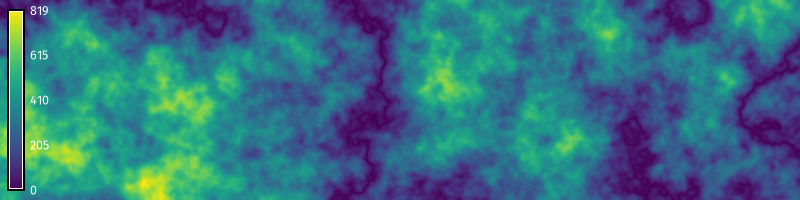
<figcaption aria-hidden="true">Multifractal Brownian motion</figcaption>
</figure>

# References

Gonzalez Vivo, Patricio, and Jen Lowe. 2015. “Fractal Brownian Motion.”
In The Book of Shaders. <https://thebookofshaders.com/13/>.

Mandelbrot, Benoît B. 1983. The Fractal Geometry of Nature. W.H.
Freeman.

Musgrave, Forest K., Craig E. Kolb, and Robert S. Mace. 1989. “The
Synthesis and Rendering of Eroded Fractal Terrains.” ACM SIGGRAPH
Computer Graphics (New York, NY, USA) 23 (3): 41–50.
<https://doi.org/10.1145/74334.74337>.

Musgrave, Forest Kenton. 2003. “Procedural Fractal Terrains.” In
Texturing and Modeling, Third Edition, edited by David S. Ebert, Forest
Kenton Musgrave, Darwyn Peachey, et al. The Morgan Kaufmann Series in
Computer Graphics. Morgan Kaufmann.
<https://doi.org/10.1016/B978-155860848-1/50045-0>.

Musgrave, Forest Kenton. 2004. “Fractal Terrains and Fractal Planets.”
In The Elements of Nature: Interactive and Realistic Techniques, edited
by Oliver Deusen, David S. Ebert, Ron Fedkiw, et al. SIGGRAPH ’04.
Association for Computing Machinery.
<https://doi.org/10.1145/1103900.1103932>.

Perlin, Ken. 1985. “An Image Synthesizer.” ACM SIGGRAPH Computer
Graphics (New York, NY, USA) 19 (3): 287–96.
<https://doi.org/10.1145/325165.325247>.

Quilez, Inigo. 2019. “Fractional Brownian Motion.”
<https://iquilezles.org/articles/fbm/>.